In [10]:
import torch; torch.manual_seed(0)
import torch.nn.functional as F
from torch.distributions import constraints

import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.distributions
import torchvision
import copy
import json
import time
import numpy as np
import pandas as  pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.distributions import Categorical

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = 'cpu'

In [11]:
X = np.genfromtxt('Data_FF/X_v3.csv', delimiter=',')
Targets = np.genfromtxt('Data_FF/Targets_v3.csv', delimiter=',')

input_scaler = MinMaxScaler()
input_scaler.fit(X)
output_scaler = MinMaxScaler()
output_scaler.fit(Targets)
X_scaled = input_scaler.transform(X)
Targets_scaled = output_scaler.transform(Targets)
SEED = 6

X_scaled, X_val_scaled, Targets_scaled, Targets_val_scaled = train_test_split(
    X_scaled, Targets_scaled,
    test_size = 0.2,
    random_state = SEED
)

X_val_scaled, X_test_scaled, Targets_val_scaled, Targets_test_scaled = train_test_split(
    X_val_scaled, Targets_val_scaled,
    test_size = 0.5,
    random_state = SEED
)

print('Total data size:', len(X), ', NaN in X:', np.any(np.isnan(X_scaled)), ', NaN in Target:', np.any(np.isnan(Targets_scaled))) 
print('Training data size:', X_scaled.shape, Targets_scaled.shape)
print('Validation data size:', X_val_scaled.shape, Targets_val_scaled.shape) 
print('Test data size:', X_test_scaled.shape, Targets_test_scaled.shape)

train_dataset = TensorDataset(torch.tensor(Targets_scaled).float(), torch.tensor(X_scaled).float())
val_dataset = TensorDataset(torch.tensor(Targets_val_scaled).float(), torch.tensor(X_val_scaled).float())
test_dataset = TensorDataset(torch.tensor(Targets_test_scaled).float(), torch.tensor(X_test_scaled).float())

train_loader = DataLoader(train_dataset, batch_size=250, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=250, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False)

Total data size: 3848 , NaN in X: False , NaN in Target: False
Training data size: (3078, 5) (3078, 101)
Validation data size: (385, 5) (385, 101)
Test data size: (385, 5) (385, 101)


In [5]:
train_dataset = TensorDataset(torch.tensor(Targets_scaled).float(), torch.tensor(X_scaled).float())
val_dataset = TensorDataset(torch.tensor(Targets_val_scaled).float(), torch.tensor(X_val_scaled).float())
test_dataset = TensorDataset(torch.tensor(Targets_test_scaled).float(), torch.tensor(X_test_scaled).float())

train_loader = DataLoader(train_dataset, batch_size=250, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=250, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False)

## Autoencoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, seq_len, latent_dim):
        super(Encoder, self).__init__()
        self.seq_len, self.latent_dim = seq_len, latent_dim
        self.layer1 = nn.Linear(seq_len, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 128)
        self.layer5 = nn.Linear(128, latent_dim)
        self.silu = nn.SiLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.silu(self.layer1(x))
        y = self.silu(self.layer2(y))
        y = self.silu(self.layer3(y))
        y = self.silu(self.layer4(y))
        y = self.sigmoid(self.layer5(y))
        return y

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, seq_len)
        self.silu = nn.SiLU()

    def forward(self, x):
        y = self.silu(self.layer1(x))
        y = self.silu(self.layer2(y))
        y = self.silu(self.layer3(y))
        y = self.silu(self.layer4(y))
        y = self.layer5(y)
        return y

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, seq_len, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(seq_len, latent_dim).to(device)
        self.decoder = Decoder(seq_len, latent_dim).to(device)

    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y

In [8]:
def train_model(model, train_loader, val_loader, n_epochs, early_stop):
    """
    This is a brief description of the function.

    Parameters:
    - param1: Model to be trained 
    - param2: Training data loader 
    - param3: Validation data loader
    - param4: Number of training epochs
    - param5: Threshold of early stopping

    Returns:
    A list of training loss at each epoch, trained model, best validation loss and corresponding training loss
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    early_stop_counter = 0
    
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        model = model.train()
        train_losses = []
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data[0])
            loss = criterion(output, data[0])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_loader):
                output = model(data[0])
                loss = criterion(output, data[0])
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        print('time: ', time.time()-start_time)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        else:    
            if (val_loss-train_loss) > 5:
                early_stop_counter += 1
                if early_stop_counter > early_stop:
                    print(f'Early stopping at epoch {epoch}')
                    break

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [12]:
model = Autoencoder(seq_len=101, latent_dim=10)
m, history = train_model(model, train_loader, val_loader, n_epochs=1000, early_stop=300)

Epoch 1: train loss 2016.3178147536057 val loss 1095.3676147460938
time:  0.09311199188232422
Epoch 2: train loss 1326.0169630784255 val loss 1004.2171020507812
time:  0.09255290031433105
Epoch 3: train loss 1244.9862201397236 val loss 1001.8081665039062
time:  0.08910894393920898
Epoch 4: train loss 1228.7138202373799 val loss 988.0927734375
time:  0.0891578197479248
Epoch 5: train loss 1194.7137310321514 val loss 963.6917724609375
time:  0.08446812629699707
Epoch 6: train loss 1162.1723257211538 val loss 925.2921142578125
time:  0.08633112907409668
Epoch 7: train loss 1041.3033329890325 val loss 784.6495666503906
time:  0.08777976036071777
Epoch 8: train loss 906.7441617525541 val loss 726.4942321777344
time:  0.08982181549072266
Epoch 9: train loss 875.0392362154447 val loss 708.0091247558594
time:  0.0887899398803711
Epoch 10: train loss 865.2156301645132 val loss 707.6327819824219
time:  0.0890660285949707
Epoch 11: train loss 860.4709284855769 val loss 699.9794616699219
time:  0.

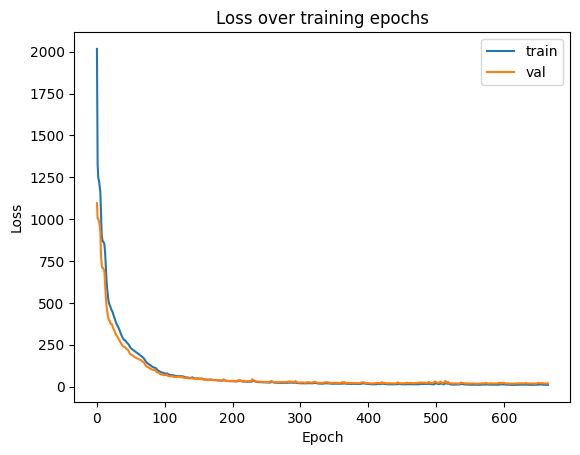

In [13]:
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show()
torch.save(m, 'new_ae.pth')

## Autoencoder Test

RMSE: 0.02776660196074928


/var/folders/9p/y3hmr72n3zj216wkt902bpcm0000gn/T/ipykernel_2379/1886130403.py:50: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[b, a+1].plot([np.min(ori[l[i]]), np.max(ori[l[i]])], [np.min(ori[l[i]]), np.max(ori[l[i]])], 'k-', linewidth=3, color = 'r')


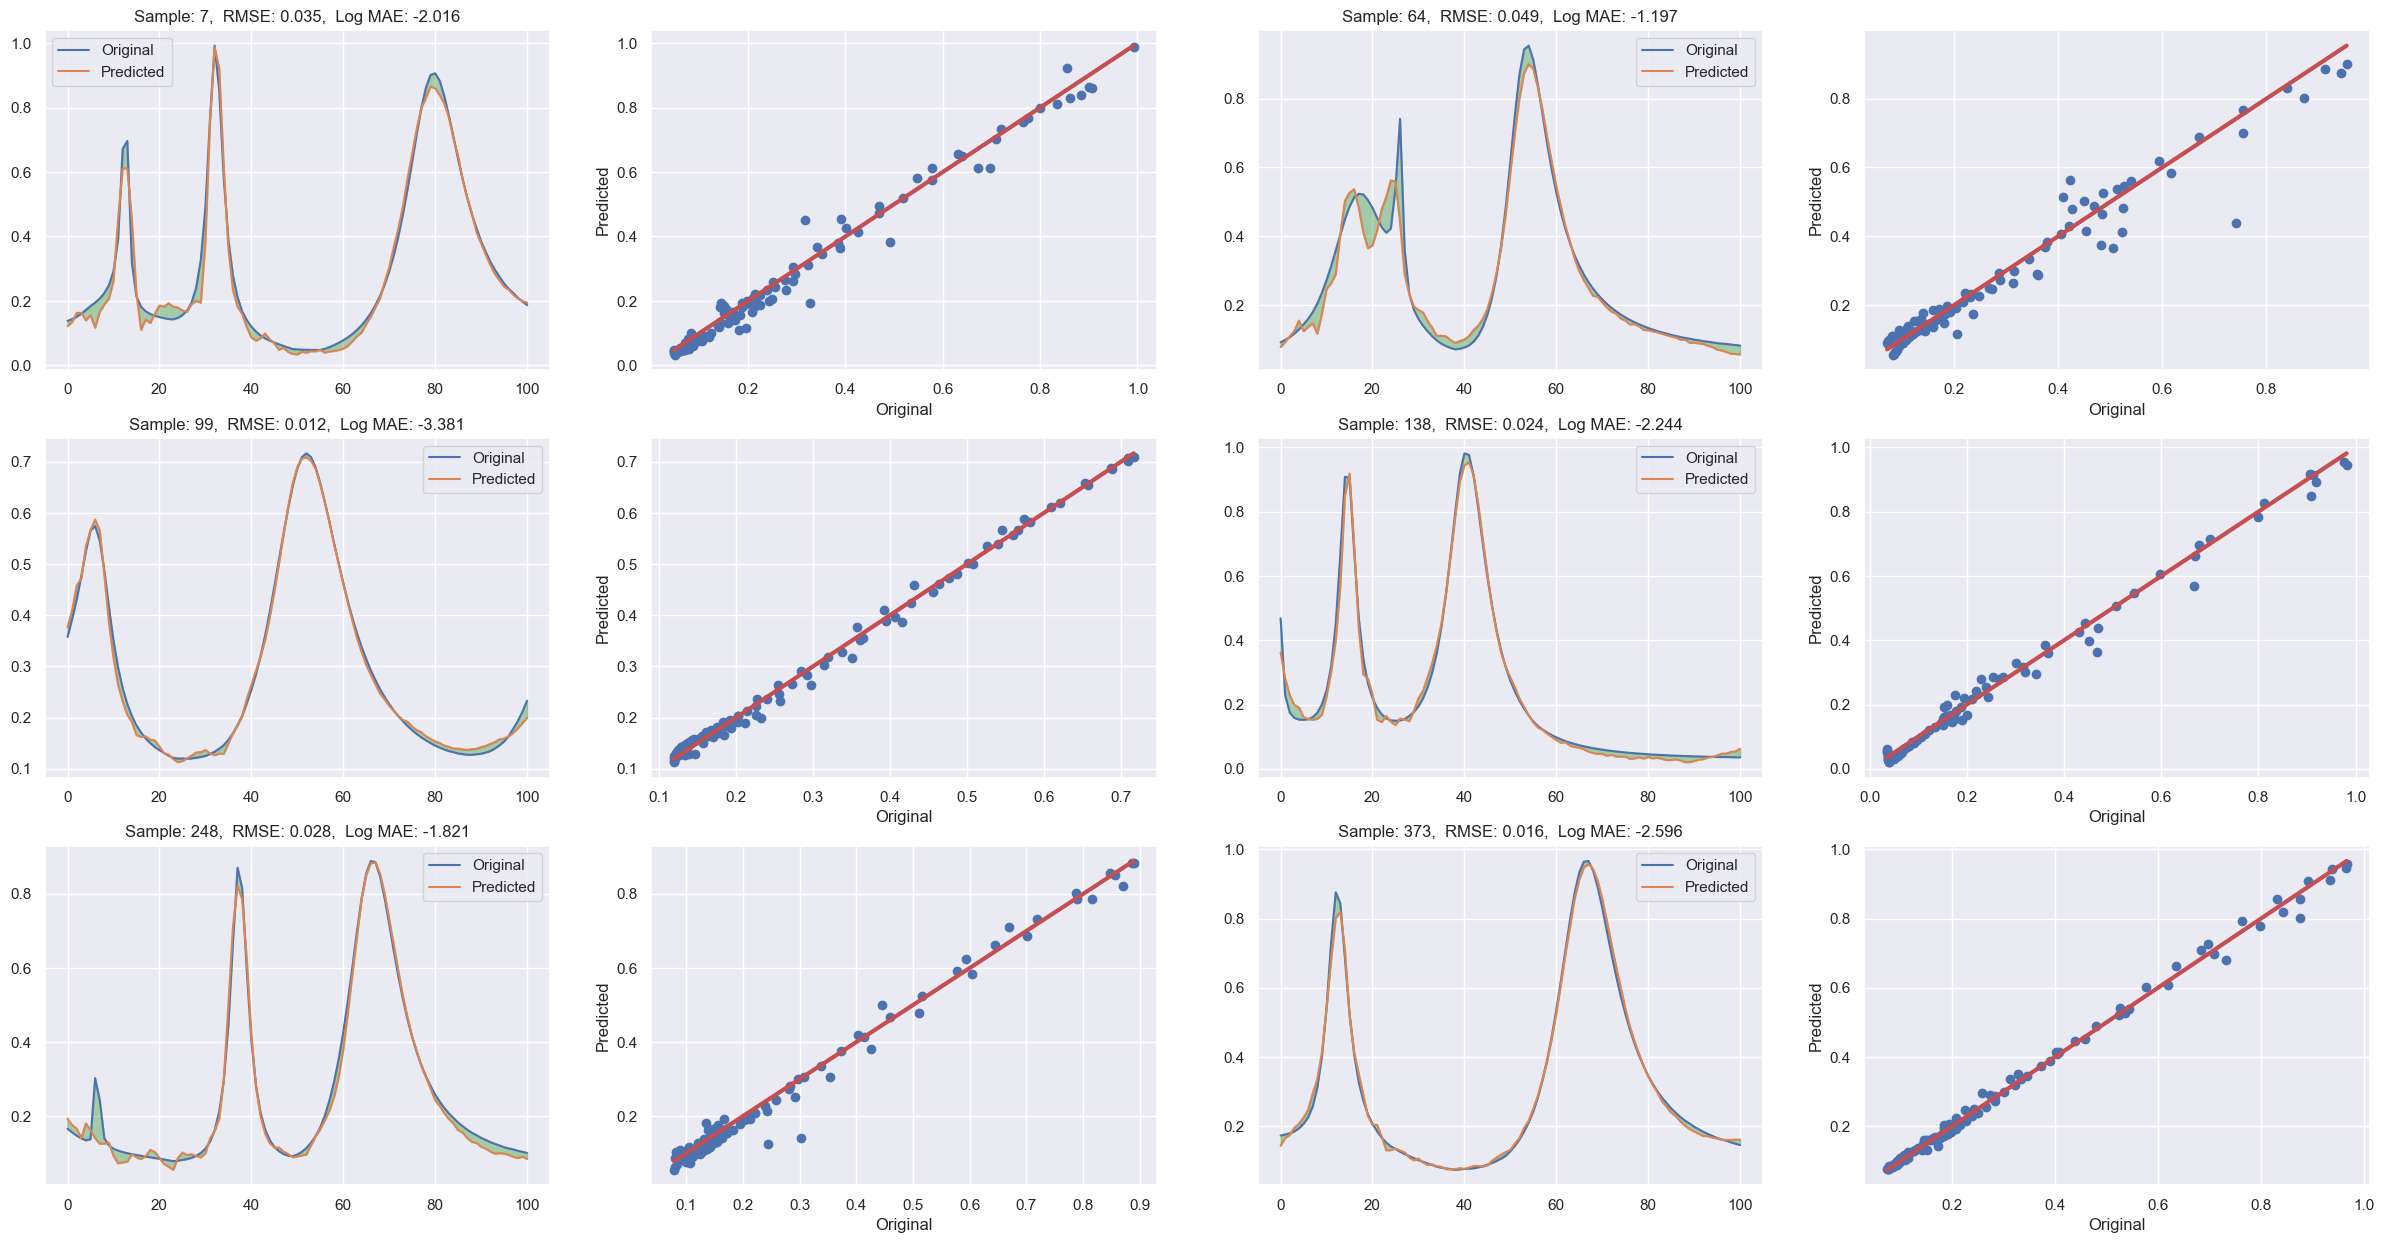

In [14]:
# Load a trained autoencoder model
m = torch.load('models/AE/ae.pth')
test, ori = [], []
for batch_idx, data in enumerate(test_loader):
    output = m(data[0])
    for i in output:
        test.append(i.tolist())
    for i in data[0]:
        ori.append(i.tolist())
        
def calc_rmse(actual, predict): 
    squared_diff = (actual - predict) ** 2
    mse = squared_diff.mean()
    rmse = np.sqrt(mse)
    return rmse

def calc_log_mae(actual, predict):
    absolute_errors = [abs(actual[i] - predict[i]) for i in range(len(actual))]
    max_absolute_error = max(absolute_errors)
    log_mae = np.log(max_absolute_error)
    return log_mae

def plot_fig(l):
    sns.set()
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))
    for i in range(len(l)):
        if i == 0 or i ==2 or i ==4:
            a = 0
        else:
            a = 2

        if i == 0 or i == 1:
            b = 0
            s = 'c'
        elif i == 2 or i == 3:
            b = 1
            s = 'a'
        else:
            b = 2
            s = 'r'

        axs[b, a].plot(ori[l[i]], label='Original')
        axs[b, a].plot(test[l[i]], label='Predicted')
        axs[b, a].fill_between(np.arange(101), ori[l[i]], test[l[i]], color='green', alpha=0.3)
        rmse = calc_rmse(np.array(ori[l[i]]), np.array(test[l[i]]))
        log_mae = calc_log_mae(np.array(ori[l[i]]), np.array(test[l[i]]))
        axs[b, a].set_title(f'Sample: {l[i]},  RMSE: {rmse:.3f},  Log MAE: {log_mae:.3f}')
        axs[b, a].legend()
        axs[b, a+1].scatter(ori[l[i]], test[l[i]])
        axs[b, a+1].plot([np.min(ori[l[i]]), np.max(ori[l[i]])], [np.min(ori[l[i]]), np.max(ori[l[i]])], 'k-', linewidth=3, color = 'r')
        axs[b, a+1].set_xlabel("Original")
        axs[b, a+1].set_ylabel("Predicted")
    plt.show()

l = [7, 64, 99, 138, 248, 373]
print('RMSE:', calc_rmse(np.array(test), np.array(ori)))
plot_fig(l)

## Summary Statistics

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, seq_len, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(seq_len, latent_dim).to(device)
        self.decoder = Decoder(seq_len, latent_dim).to(device)

    def forward(self, x):
        y = self.encoder(x)
        #y = self.decoder(y)
        return y

In [11]:
def cal_summary_stat(model, loader):
    dic = dict(parameter=[], data=[], summary_statistics=[])
    for batch_idx, (data, parm) in enumerate(loader):
        output = model(data)
        for i in output:
            dic['summary_statistics'].append(i.tolist())
        for i in data:
            dic['data'].append(i.tolist())
        for i in parm:
            dic['parameter'].append(i.tolist())
    
    return dic

ae = torch.load('models/AE/ae.pth')
train = cal_summary_stat(ae, train_loader)
val = cal_summary_stat(ae, val_loader)
test = cal_summary_stat(ae, test_loader)

# save summary statistics to json
with open("train_summary_stat.json", "w") as file:
    json.dump(train, file)

with open("val_summary_stat.json", "w") as file:
    json.dump(val, file)

with open("test_summary_stat.json", "w") as file:
    json.dump(test, file)